<a href="https://colab.research.google.com/github/Jamana3/Image_Processing1/blob/main/MCS_project_1_(MS22117).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I implement a stochastic cellular automaton (CA) model to study tumor growth and treatment dynamics on a two-dimensional lattice. In the model, I represent biological tissue as a grid in which each lattice site corresponds to a small local region that can be occupied by a **normal cell**, a **cancer cell**, a **necrotic cell**, or **remain empty**. The evolution of the system is governed by local interaction rules based on the Moore neighborhood. Cancer progression emerges from probabilistic proliferation, spatial competition for empty sites, and a growth potential variable that accumulates over time. A feedback mechanism reduces the effective mitotic probability as the ratio of normal to cancer cells changes, introducing global regulation into the local rules. Necrosis—defined biologically as the death of cells due to insufficient nutrients or oxygen—appears in the model when cancer cells become spatially confined and exceed a growth threshold. Treatment is incorporated by modifying proliferation probabilities and allowing drug-induced cancer cell death. Through these simple local rules, the CA framework generates complex spatial patterns and time-dependent population dynamics that qualitatively reproduce different tumor growth scenarios.                                                
(Source Paper: https://www.sciencedirect.com/science/article/abs/pii/S0378437108009849)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from matplotlib.colors import ListedColormap

EMPTY = 0
NORMAL = 1
CANCER = 2
NECROTIC = 3


cmap_custom = ListedColormap([
    "#000000",  # EMPTY - black
    "#2ECC71",  # NORMAL - green
    "#E74C3C",  # CANCER - red
    "#8E44AD"   # NECROTIC - purple
])

In [7]:
def get_neighbors(i, j, L):
    return [((i+di)%L, (j+dj)%L)
            for di in [-1,0,1]
            for dj in [-1,0,1]
            if not (di==0 and dj==0)]

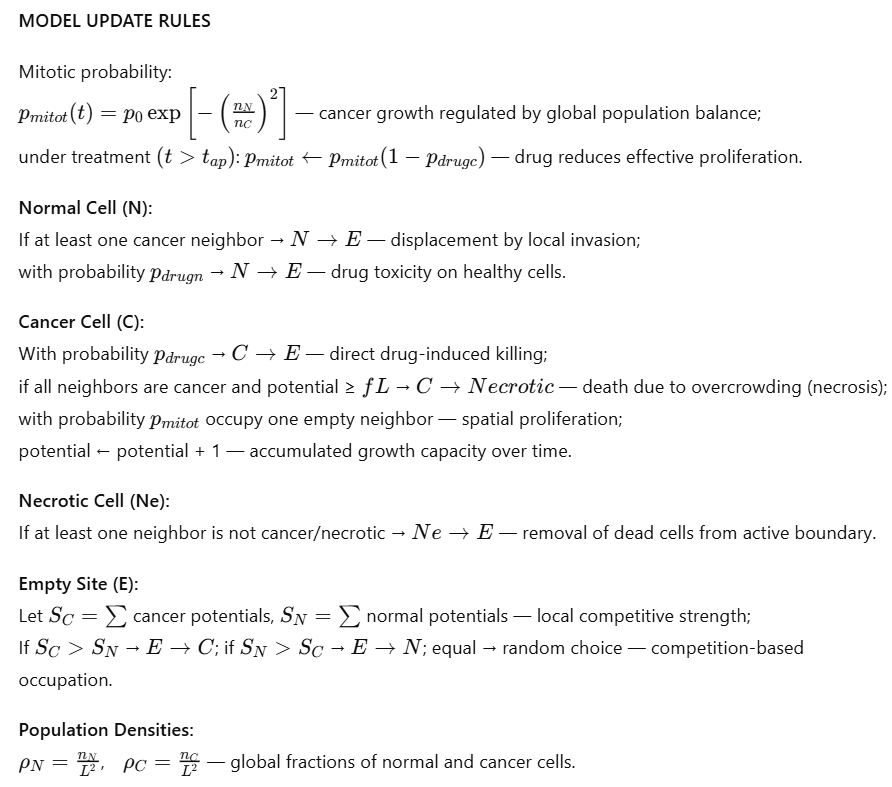

In [2]:
def run_simulation(
    L=101,
    tfinal=400,
    p0=0.5,
    f=0.2,
    pdrugn=0.0,
    pdrugc=0.0,
    tap=0,
    record_spatial=True
):

    state = np.full((L,L), NORMAL, dtype=int)
    potential = np.zeros((L,L))

    center = L//2
    state[center, center] = CANCER
    potential[center, center] = 1

    densities_normal = []
    densities_cancer = []
    snapshots = []

    for t in range(tfinal):

        n_normal = np.sum(state == NORMAL)
        n_cancer = np.sum(state == CANCER)

        if n_cancer > 0:
            delta_p = np.exp(-(n_normal/n_cancer)**2)
        else:
            delta_p = 0

        p_mitot = p0 * delta_p

        if t > tap:
            p_mitot = p_mitot * (1 - pdrugc)

        indices = [(i,j) for i in range(L) for j in range(L)]
        np.random.shuffle(indices)

        for (i,j) in indices:

            # 1)---------------- NORMAL CELL update rules----------------
            if state[i,j] == NORMAL:

                if t > tap and np.random.rand() < pdrugn:
                    state[i,j] = EMPTY
                    continue

                neighbors = get_neighbors(i,j,L)
                if any(state[x,y] == CANCER for (x,y) in neighbors):
                    state[i,j] = EMPTY

            # ---------------- CANCER cell update rules----------------
            elif state[i,j] == CANCER:

                neighbors = get_neighbors(i,j,L)

                if t > tap and np.random.rand() < pdrugc:
                    state[i,j] = EMPTY
                    potential[i,j] = 0
                    continue

                # a)Necrosis
                if all(state[x,y] == CANCER for (x,y) in neighbors) \
                   and potential[i,j] >= f*L:
                    state[i,j] = NECROTIC
                    potential[i,j] = 0
                    continue

                # b)Proliferation
                if np.random.rand() < p_mitot:
                    empty_neighbors = [(x,y) for (x,y) in neighbors
                                       if state[x,y] == EMPTY]
                    if empty_neighbors:
                        x,y = empty_neighbors[np.random.randint(len(empty_neighbors))]
                        state[x,y] = CANCER
                        potential[x,y] = 1

                potential[i,j] += 1

            # c)---------------- NECROTIC cell update rule----------------
            elif state[i,j] == NECROTIC:

                neighbors = get_neighbors(i,j,L)
                if any(state[x,y] not in (CANCER, NECROTIC)
                       for (x,y) in neighbors):
                    state[i,j] = EMPTY

            # d)---------------- EMPTY site----------------
            elif state[i,j] == EMPTY:

                neighbors = get_neighbors(i,j,L)

                cancer_neighbors = [(x,y) for (x,y) in neighbors
                                    if state[x,y] == CANCER]
                normal_neighbors = [(x,y) for (x,y) in neighbors
                                    if state[x,y] == NORMAL]

                if cancer_neighbors and normal_neighbors:

                    sum_cancer = sum(potential[x,y] for (x,y) in cancer_neighbors)
                    sum_normal = sum(potential[x,y] for (x,y) in normal_neighbors)

                    if sum_cancer > sum_normal:
                        x,y = cancer_neighbors[np.random.randint(len(cancer_neighbors))]
                        state[i,j] = CANCER
                        potential[i,j] = 1
                    elif sum_normal > sum_cancer:
                        state[i,j] = NORMAL
                    else:
                        if np.random.rand() < 0.5:
                            x,y = cancer_neighbors[np.random.randint(len(cancer_neighbors))]
                            state[i,j] = CANCER
                            potential[i,j] = 1
                        else:
                            state[i,j] = NORMAL

                elif cancer_neighbors:
                    x,y = cancer_neighbors[np.random.randint(len(cancer_neighbors))]
                    state[i,j] = CANCER
                    potential[i,j] = 1

                elif normal_neighbors:
                    state[i,j] = NORMAL

        densities_normal.append(np.sum(state==NORMAL)/(L*L))
        densities_cancer.append(np.sum(state==CANCER)/(L*L))

        if record_spatial and t % 5 == 0:
            snapshots.append(state.copy())

    return densities_normal, densities_cancer, snapshots



In [8]:
def animate(snapshots):
    fig, ax = plt.subplots()
    im = ax.imshow(snapshots[0], cmap=cmap_custom, vmin=0, vmax=3)

    def update(frame):
        im.set_array(snapshots[frame])
        ax.set_title(f"Step {frame*5}")
        return [im]

    ani = animation.FuncAnimation(fig, update,
                                  frames=len(snapshots),
                                  interval=100)

    plt.close()
    return HTML(ani.to_jshtml())

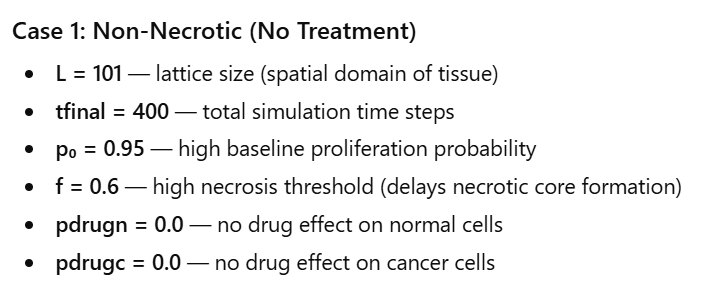

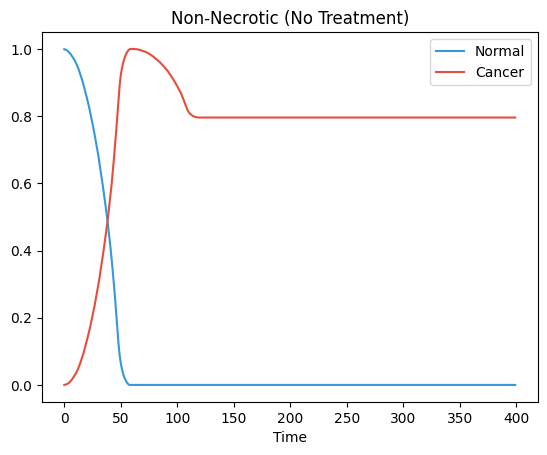

In [3]:

normal, cancer, snapshots = run_simulation(
    L=101,
    tfinal=400,
    p0=0.95,
    f=0.6,
    pdrugn=0.0,
    pdrugc=0.0
)

plt.plot(normal, color="#3498DB", label="Normal")
plt.plot(cancer, color="#E74C3C", label="Cancer")
plt.legend()
plt.title("Non-Necrotic (No Treatment)")
plt.xlabel("Time")
plt.show()

animate(snapshots)

**Result Interpretation:**
Rapid tumor expansion occurs due to high proliferation and absence of treatment, while the large
𝑓
f value prevents necrosis, producing a viable (non-necrotic) or necrocis develop very late, tumor mass.
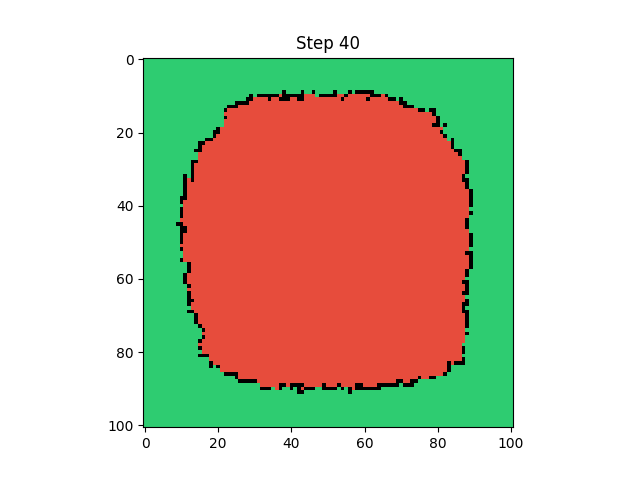

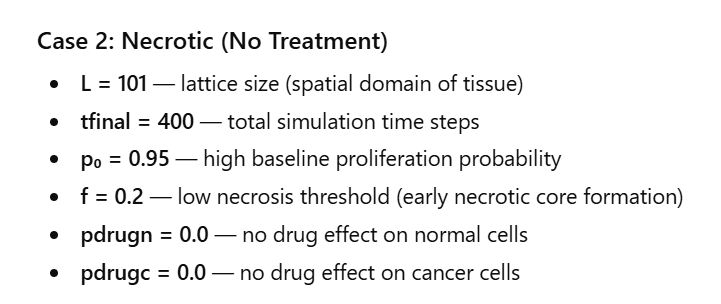

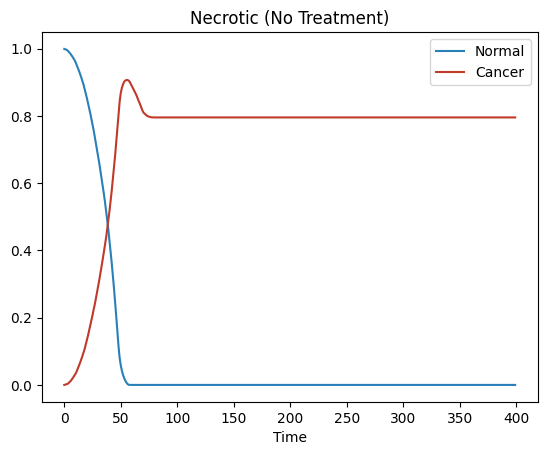

In [4]:
normal, cancer, snapshots = run_simulation(
    L=101,
    tfinal=400,
    p0=0.95,
    f=0.2,
    pdrugn=0.0,
    pdrugc=0.0
)

plt.plot(normal, color="#2980B9", label="Normal")
plt.plot(cancer, color="#C0392B", label="Cancer")
plt.legend()
plt.title("Necrotic (No Treatment)")
plt.xlabel("Time")
plt.show()

animate(snapshots)

**Result Interpretation:**
Rapid tumor expansion occurs due to high proliferation, but the low
𝑓
f value allows necrosis (cell death due to overcrowding and limited resources) to appear early, leading to the formation of a necrotic core within the growing tumor mass.
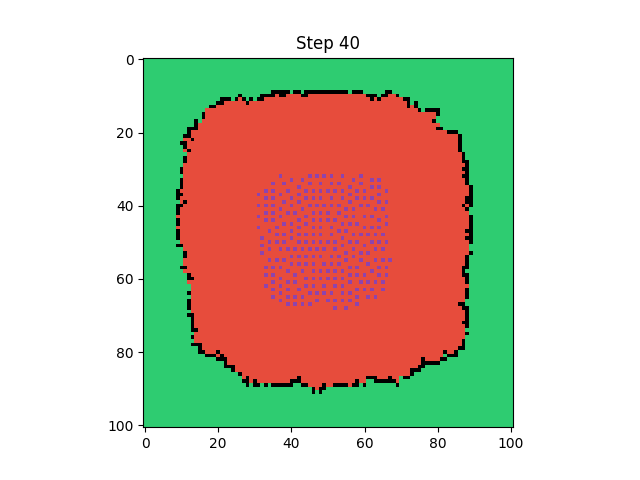

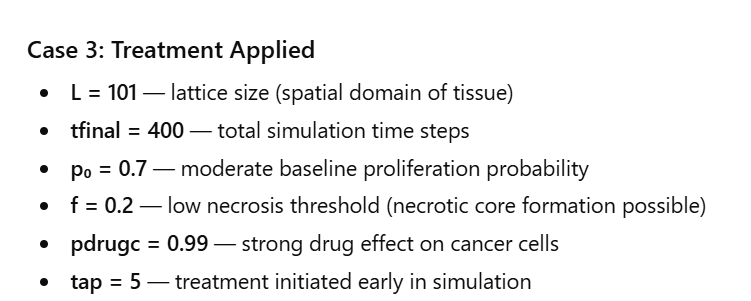

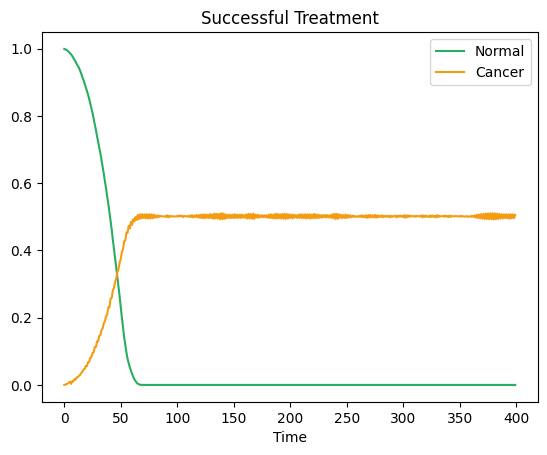

In [5]:
normal, cancer, snapshots = run_simulation(
    L=101,
    tfinal=400,
    p0=0.7,
    f=0.2,
    pdrugc=0.99,
    tap=5
)

plt.plot(normal, color="#27AE60", label="Normal")
plt.plot(cancer, color="#F39C12", label="Cancer")
plt.legend()
plt.title(" Treatment")
plt.xlabel("Time")
plt.show()

animate(snapshots)

**Result Interpretation:**
Treatment begins at an early stage and strongly suppresses cancer proliferation while directly killing cancer cells. The moderate growth rate combined with high drug efficacy reduces tumor expansion and can lead to cancer decline, depending on spatial dynamics and local competition with normal cells.
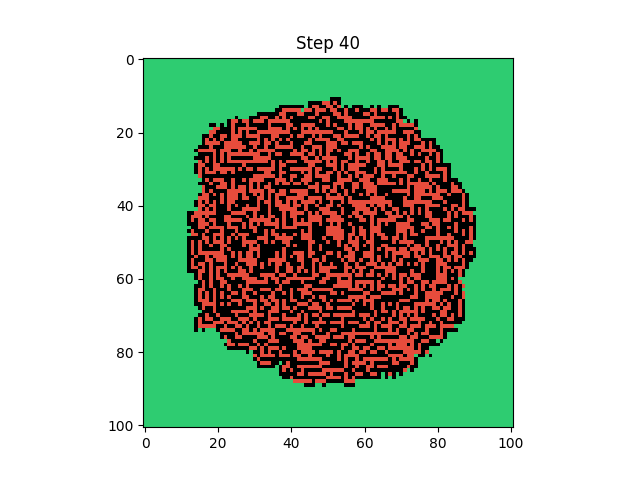

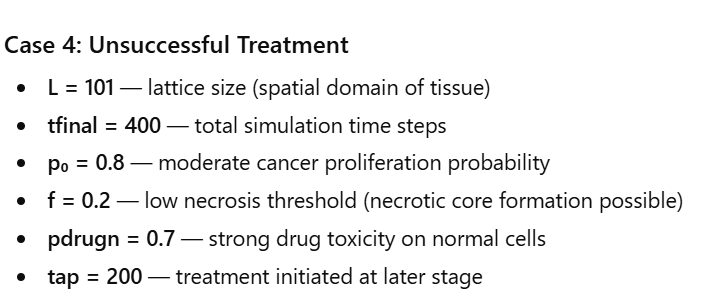

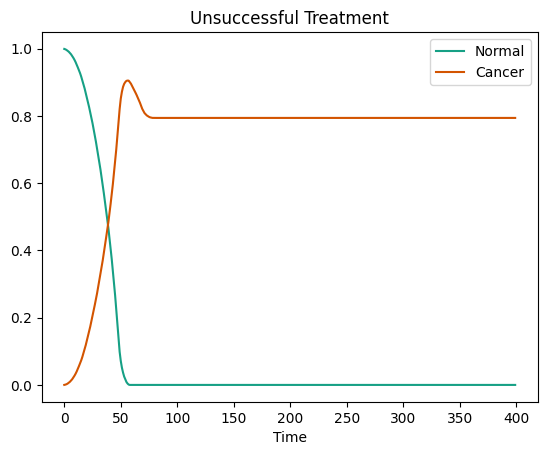

In [6]:
normal, cancer, snapshots = run_simulation(
    L=101,
    tfinal=400,
    p0=0.8,
    f=0.2,
    pdrugn=0.7,
    tap=200
)

plt.plot(normal, color="#16A085", label="Normal")
plt.plot(cancer, color="#D35400", label="Cancer")
plt.legend()
plt.title("Unsuccessful Treatment")
plt.xlabel("Time")
plt.show()

animate(snapshots)

**Result Interpretation:**
Treatment is applied late and primarily affects normal cells rather than cancer cells. Since cancer proliferation is not directly suppressed, the tumor continues to grow while normal tissue is further reduced. This leads to treatment failure, where cancer density remains high despite drug application.
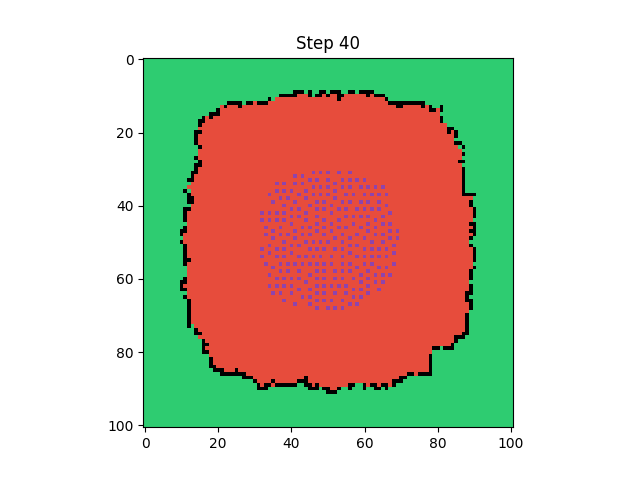